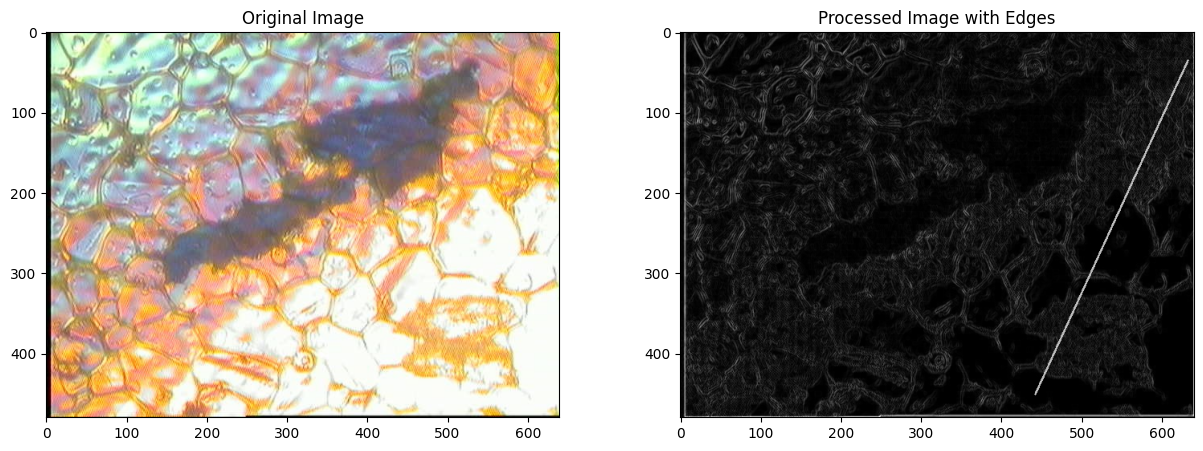

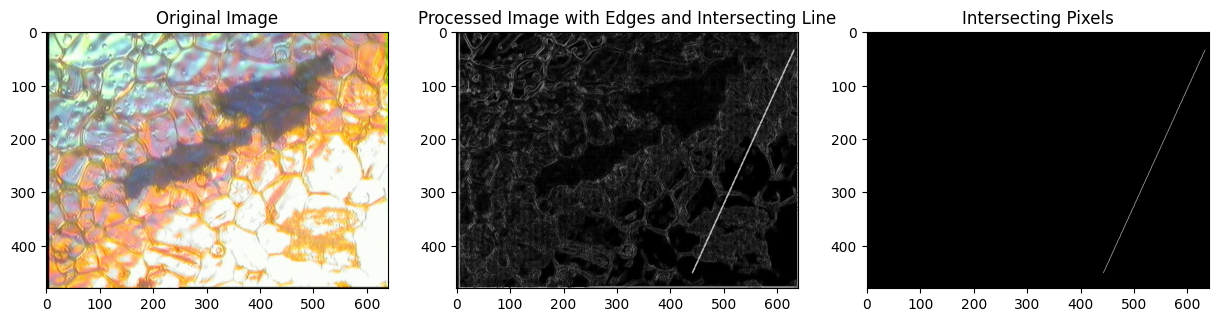

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d

# Load the image
img = Image.open('./source/2h_milling1200C_2h.jpg')

# Convert the image to grayscale
gray = img.convert('L')

# Convert the grayscale image to a NumPy array
img_array = np.array(gray)

# Define the Sobel filter
sobel_filter = np.array([[-1], [0], [1]])

# Apply the Sobel filter to the image
edge_x = np.abs(convolve2d(img_array, sobel_filter, mode="same"))
edge_y = np.abs(convolve2d(img_array, sobel_filter.T, mode="same"))
edge = edge_x + edge_y
edge = edge.reshape(img_array.shape)

# Draw a random line on the processed image
h, w = edge.shape
start_point = (np.random.randint(w), np.random.randint(h))
end_point = (np.random.randint(w), np.random.randint(h))
color = (255, 0, 0)
thickness = 2
cv2.line(edge, start_point, end_point, color, thickness)

# Display the original image, the processed image with edges, and the processed image with edges and a line
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(edge, cmap='gray')
axs[1].set_title('Processed Image with Edges')
plt.show()

# Create a boolean mask of the pixels where the edge intersects with the line
mask = np.zeros_like(edge, dtype=np.uint8)
cv2.line(mask, start_point, end_point, 255, thickness=1)
edge = edge.astype(np.uint8)

# Get the intersecting pixels between the edge image and the line mask
intersecting_pixels = cv2.bitwise_and(mask, edge)

# Modify the color of the intersecting pixels in the edge array
edge[intersecting_pixels > 0] = 127

# Display the original image, the processed image with edges, and the processed image with edges and a line
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(edge, cmap='gray')
axs[1].set_title('Processed Image with Edges and Intersecting Line')

# Display the mask image with the intersecting pixels
axs[2].imshow(intersecting_pixels, cmap='gray')
axs[2].set_title('Intersecting Pixels')
plt.show()

# Save the modified image
img_output = Image.fromarray(edge)
img_output = img_output.convert("RGB")
img_output.save("output.jpg")

In [18]:
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

# Load the DeepLabv3 model
interpreter = tf.lite.Interpreter(model_path="./deeplabv3_1_default_1.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the image
img = Image.open('./source/18h_milling1200C_2h.jpg').convert('RGB')
img = img.resize((257, 257))

# Preprocess the image
input_data = np.expand_dims(img, axis=0).astype(input_details[0]['dtype'])
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the model
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Threshold the output to create a binary mask
threshold = 0.5
mask = (output_data > threshold).astype(np.uint8) * 255

# Convert the mask to a grayscale image
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# Resize the mask to match the size of the original image
mask = cv2.resize(mask, (img.size[0], img.size[1]))

# Convert the original image to an array
img_array = np.array(img)

# Convert the image to grayscale and add a third channel
gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

# Apply the mask to the grayscale image
mask_resized = cv2.resize(mask, (gray.shape[1], gray.shape[0]))
print("mask_resized shape:", mask_resized.shape, "mask dtype:", mask_resized.dtype)
print("gray shape:", gray.shape, "gray dtype:", gray.dtype)
edge = cv2.bitwise_and(gray, mask_resized)

# Find the intersecting pixels between the mask and the original image
crossing_pixels = cv2.bitwise_and(mask, edge)

# Apply the boolean mask to modify only the intersecting pixels
edge[crossing_pixels > 0] = 255


# Save the modified image
img_output = Image.fromarray(edge)
img_output.save('./output/deeplabv3_edge_detection.jpg')

mask_resized shape: (257, 257, 3) mask dtype: uint8
gray shape: (257, 257, 3) gray dtype: uint8
